<a href="https://colab.research.google.com/github/OshidiWeerakulasuriya/User-interest-and-hotel-feature-identification-model/blob/main/TweetsLSATopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github ref for this code - https://github.com/jayfeng1/hostel_reviews_nltk/blob/master/hostel_review.py

In [ ]:
# MONKEYLEARN SETTINGS
# Put here your MonkeyLearn API token
MONKEYLEARN_TOKEN = '17eda6bd29bc6a7d72736ace1ed2e89623104143'

In [ ]:
amenities = {
'wifi':      ['wifi','internet','wi-fi', 'wi fi', 'wireless'],
'breakfast': ['breakfast', 'breakfest', 'break fast', 'brunch'],
'bathroom':  ['bathroom', 'bath room', 'bath', 'restroom', 'toilet', 
              'urinal', 'lavatory', 'washroom'],
'shower':    ['shower', 'bathe', 'showers'],
'noise':     ['noise', 'noisy', 'quiet', 'loud', 'silent']
}

In [ ]:
import re

def count_amenities(hostel, key):
    """ If key/amenity found in review, apply phrase in key column """
    hostel[key] = hostel.apply(lambda x: 
        get_key_sentence(x['review'], amenities[key]), axis=1)
    return hostel
    
def get_key_sentence(x, key_list):
    """Passes in a review and a bag of words associated with the key
       Returns a sentence in the review containing one or more of the bag of words
    """
    delimiters = ',', '.', ';', '!', '?'
    sentences = split(delimiters, x, maxsplit=0)
    for sent in sentences: 
        for word in sent.split(): #loop through words in phrase
            if word.lower() in key_list:
                return sent.lower().strip() #return phrase

def split(delimiters, string, maxsplit=0):
    """ Takes in comma separated delimiters and splits paragraph string
        into a list of phrases """
    regexPattern = '|'.join(map(re.escape, delimiters))
    return re.split(regexPattern, string, maxsplit)

In [ ]:
import numpy as np  
from textblob import TextBlob
import nltk
from nltk.util import ngrams
from nltk.collocations import *
from collections import Counter

#subset = hostel.dropna() #drop reviews not mentioning key
#subset.reset_index(inplace=True) 

#Apply sentiment values to each phrase 
subset['sentiment'] = subset[key].apply(lambda x: 
    TextBlob(x).sentiment.polarity)

NameError: ignored

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from collections import Counter

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

import gensim
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

In [3]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
convosdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TwitterData/Kalanasw_tweets.csv")

In [9]:

regex ="\B@\w+"
convosdf.text = convosdf.text.str.replace(regex, '')

In [10]:
regex ="http\S+"
convosdf.text = convosdf.text.str.replace(regex, '')

In [11]:
convosdf.head()


,id,created_at,text
0,1324992654183174144,2020-11-07 08:30:40,South Coast of Sri Lanka\n#dikwella\n\n#srilan...
1,1318205401712726016,2020-10-19 15:00:33,#sunset #aesthetics #beach\nSong: Jeremy Zucke...
2,1317801656566927360,2020-10-18 12:16:13,Just posted a video @ Sri Lanka
3,1310094970859278337,2020-09-27 05:52:36,#FromWhereIDrone #behindthescenes #djimavicair...
4,1309867393447936000,2020-09-26 14:48:17,Just posted a photo @ දික්වැල්ල


In [12]:
# removing everything except alphabets`
convosdf['clean_text'] = convosdf['text'].str.replace("[^a-zA-Z#]", " ")

# removing short words
convosdf['clean_text'] = convosdf['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
convosdf['clean_text'] = convosdf['clean_text'].apply(lambda x: x.lower())

In [13]:
convos = convosdf.clean_text.tolist()


In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
split_convos = list(sent_to_words(convos))

In [15]:
all_words = [word for convo in split_convos for word in convo]

for word in all_words:
    word = word.lower()

In [16]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [18]:
nltk.download('stopwords')

domain_stopwords = ['thank', 'dm', 'issue', 'app', 'order', 'phone', 'number', 'account', 'service', 'time',
                    'link', 'apology', 'direct_message', 'thanks', 'help', 'email', 'sorry', 'team', 'issues',
                    'just', 'like', 'hello', 'assist', 'want', 'know', 'idea', 'details', 'check', 'look', 
                    'make', 'need', 'soon', 'check', 'send', 'private', 'message', 'kindly', 'rgds', 'still', 
                    'customer', 'regard', 'please', 'would']

english_stopwords = stopwords.words('english')

clean_convos = []

for convo in split_convos:
    no_stop = [word for word in convo if word not in english_stopwords]
    
    no_domain = [word for word in no_stop if word not in domain_stopwords]

    clean_words = [get_lemma(word) for word in no_domain]
    
    clean_convos.append(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
vectorizer = CountVectorizer(min_df=0.005, max_df=0.995, tokenizer=lambda doc: doc, lowercase=False)

doc_word = vectorizer.fit_transform(clean_convos)
doc_word.toarray().shape


(3240, 53)

In [20]:
len(vectorizer.get_feature_names())


53

In [21]:
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.46947107, 0.05639886, 0.05235616, 0.03132707, 0.02451829])

In [22]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5"], columns = vectorizer.get_feature_names())
topic_word

,avenger,battle,beach,behind,best,dickwella,djispark,drone,dronevideo,eminem,epic,explain,facebook,first,full,game,gopro,infinity,iphone,koombiyo,lanka,like,live,lyric,marvel,movie,music,nature,netflix,official,part,photo,photography,photooftheday,photoshop,post,scene,sea,season,sky,song,spider,srilanka,sunset,teaser,throne,trailer,travel,travelgram,version,video,vlog,watching
component_1,0.010,0.009,0.003,0.015,0.012,0.002,0.001,0.009,0.002,0.028,0.009,0.010,0.008,0.008,0.011,0.017,0.008,0.011,0.013,0.007,0.015,0.654,0.015,0.013,0.009,0.015,0.033,0.000,0.009,0.093,0.008,0.001,0.001,0.000,0.001,0.019,0.013,0.000,0.010,0.000,0.022,0.013,0.002,0.001,0.014,0.013,0.064,0.006,0.000,0.008,0.744,0.004,0.002
component_2,-0.009,-0.000,0.428,0.002,0.010,0.176,0.103,0.084,0.097,0.000,0.000,0.001,0.005,0.004,0.023,-0.006,0.204,-0.009,0.001,-0.000,0.226,-0.015,0.011,-0.002,-0.010,-0.007,-0.002,0.251,-0.009,-0.087,0.004,0.056,0.241,0.213,0.011,0.012,0.001,0.216,-0.006,0.189,0.009,-0.008,0.397,0.390,-0.012,-0.003,-0.091,0.254,0.137,-0.001,0.016,0.055,-0.000
component_3,0.058,-0.014,0.056,-0.017,-0.021,0.021,0.013,-0.006,0.012,-0.049,-0.016,-0.019,-0.006,0.004,-0.011,0.037,0.015,0.054,-0.026,0.011,0.006,-0.157,-0.035,0.015,0.068,0.038,0.109,0.036,0.061,0.690,-0.012,0.005,0.033,0.031,-0.000,-0.025,-0.026,0.031,0.034,0.027,-0.007,0.051,0.055,0.057,0.084,0.021,0.658,0.028,0.020,-0.000,-0.013,0.001,0.002
component_4,-0.085,-0.020,-0.023,-0.016,-0.012,0.006,0.022,0.029,0.041,-0.003,-0.013,-0.003,0.209,-0.007,0.061,-0.074,-0.021,-0.099,-0.025,-0.039,0.063,-0.491,-0.029,0.084,-0.078,-0.073,0.299,-0.033,-0.034,0.339,-0.008,0.008,-0.023,-0.025,-0.004,0.253,-0.012,-0.024,-0.048,-0.027,0.026,-0.039,0.033,-0.049,-0.045,-0.050,-0.447,-0.031,-0.010,-0.009,0.415,-0.001,-0.011
component_5,0.015,-0.006,0.130,0.007,0.015,0.218,0.093,-0.017,0.168,-0.022,-0.005,-0.003,-0.016,0.009,0.045,-0.033,-0.077,0.019,-0.005,0.013,0.750,0.022,0.002,-0.017,0.017,0.012,-0.030,-0.235,0.002,-0.062,0.032,-0.064,-0.216,-0.122,-0.008,0.001,-0.002,-0.066,-0.011,-0.130,0.022,0.013,0.192,-0.234,0.007,-0.029,0.098,-0.263,-0.036,0.000,-0.032,-0.042,-0.005


In [23]:
cols = topic_word.columns.tolist()


In [25]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [26]:
display_topics(lsa, vectorizer.get_feature_names(), 10)



Topic  0
video, like, official, trailer, music, eminem, song, post, game, live

Topic  1
beach, srilanka, sunset, travel, nature, photography, lanka, sea, photooftheday, gopro

Topic  2
official, trailer, music, teaser, marvel, netflix, avenger, sunset, beach, srilanka

Topic  3
video, official, music, post, facebook, lyric, lanka, full, dronevideo, srilanka

Topic  4
lanka, dickwella, srilanka, dronevideo, beach, trailer, djispark, full, part, song


In [27]:
Vt = pd.DataFrame(doc_topic.round(3),
             index = convos,
             columns = ["component_1","component_2", "component_3", "component_4", "component_5"])

In [28]:
num_components = np.arange(1,20).tolist()
var = []

for num in num_components:
    
    lsa = TruncatedSVD(num)
    doc_topic = lsa.fit_transform(doc_word)
    var.append(lsa.explained_variance_ratio_)

In [29]:

var = [v.tolist() for v in var]

var_steps = []

idx = 0
for v in var:
    var_steps.append(v[idx])
    idx += 1

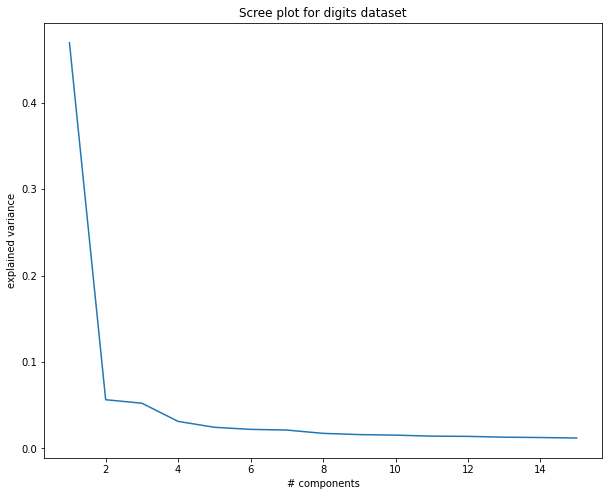

In [30]:
plt.figure(figsize=(10,8))
plt.plot(num_components[:15], var_steps[:15])
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for digits dataset');

In [31]:

nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [32]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), index = ["component_1","component_2", "component_3",
                                                                   "component_4","component_5"], 
                          columns = vectorizer.get_feature_names())
topic_word

,avenger,battle,beach,behind,best,dickwella,djispark,drone,dronevideo,eminem,epic,explain,facebook,first,full,game,gopro,infinity,iphone,koombiyo,lanka,like,live,lyric,marvel,movie,music,nature,netflix,official,part,photo,photography,photooftheday,photoshop,post,scene,sea,season,sky,song,spider,srilanka,sunset,teaser,throne,trailer,travel,travelgram,version,video,vlog,watching
component_1,0.026,0.068,0.000,0.109,0.092,0.000,0.000,0.045,0.000,0.214,0.068,0.078,0.000,0.057,0.038,0.088,0.050,0.032,0.102,0.040,0.020,4.807,0.122,0.024,0.014,0.075,0.000,0.000,0.019,0.000,0.057,0.004,0.000,0.000,0.009,0.000,0.102,0.000,0.042,0.000,0.135,0.050,0.000,0.000,0.032,0.075,0.000,0.028,0.000,0.054,4.812,0.026,0.008
component_2,0.000,0.000,1.335,0.000,0.013,0.270,0.201,0.306,0.042,0.000,0.000,0.000,0.000,0.009,0.000,0.005,0.898,0.000,0.000,0.003,0.000,0.000,0.029,0.000,0.000,0.000,0.000,1.209,0.000,0.000,0.000,0.276,1.142,0.953,0.048,0.000,0.000,0.906,0.000,0.871,0.007,0.000,1.129,1.768,0.000,0.005,0.000,1.223,0.573,0.000,0.003,0.249,0.000
component_3,0.337,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.032,0.000,0.227,0.000,0.339,0.000,0.101,0.000,0.476,0.000,0.000,0.373,0.245,0.000,0.000,0.288,1.811,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.189,0.000,0.000,0.282,0.000,0.000,0.395,0.129,3.186,0.000,0.000,0.014,0.000,0.000,0.019
component_4,0.000,0.000,0.000,0.000,0.000,0.000,0.017,0.062,0.037,0.000,0.000,0.000,0.401,0.000,0.132,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.229,0.000,0.000,0.876,0.000,0.000,1.414,0.000,0.013,0.007,0.000,0.000,0.496,0.000,0.000,0.000,0.000,0.087,0.000,0.021,0.000,0.003,0.000,0.000,0.000,0.000,0.005,2.379,0.004,0.003
component_5,0.000,0.000,0.860,0.011,0.038,0.797,0.374,0.064,0.603,0.000,0.000,0.000,0.000,0.022,0.157,0.000,0.000,0.000,0.000,0.004,2.363,0.000,0.008,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.082,0.000,0.000,0.000,0.000,0.026,0.000,0.056,0.000,0.000,0.036,0.000,0.903,0.000,0.000,0.000,0.000,0.000,0.034,0.000,0.038,0.008,0.000


In [33]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)



Topic  0
video, like, eminem, song, live, behind, scene, iphone, best, game

Topic  1
sunset, beach, travel, nature, photography, srilanka, photooftheday, sea, gopro, sky

Topic  2
trailer, official, like, teaser, marvel, infinity, avenger, netflix, spider, movie

Topic  3
video, official, music, post, facebook, lyric, full, song, drone, dronevideo

Topic  4
lanka, srilanka, beach, dickwella, dronevideo, djispark, full, part, drone, sea


In [34]:
topic_vectors_df = pd.DataFrame(doc_topic.round(5), index = convos,
             columns = ["component_1","component_2", "component_3", "component_4", "component_5"])

In [37]:
ids = convosdf.id.tolist()
topic_vectors_df['id'] = ids

In [38]:
topic_vectors_df.head(3)


,component_1,component_2,component_3,component_4,component_5,id
south coast lanka #dikwella #srilankatravel #srilanka #srilankadaily #srianka #music #bns #travel #inspiration #beachsunrise #beach #southsrilanka #dronevideo #dikwella #dikwellabeach lanka,0.00000,0.11211,0.0,0.08636,0.81728,1324992654183174144
#sunset #aesthetics #beach song jeremy zucker kids depressed slowed down #dronevideo #cinematic #mavicair #djiglobal #srilanka #kalanasw #aerialphotography #lyricedits #droneshots,0.00000,0.25966,0.0,0.00981,0.20804,1318205401712726016
just posted video lanka,0.03569,0.00000,0.0,0.27035,0.28422,1317801656566927360


In [39]:
topic_vectors_df.to_pickle("./topic_vectors.pkl")


In [40]:
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.995, tokenizer=lambda doc: doc, lowercase=False)
doc_word_tf = tfidf.fit_transform(clean_convos)
doc_word_tf.shape

(3240, 53)

In [41]:
nmf_model_tf = NMF(5)
doc_topic_tf = nmf_model_tf.fit_transform(doc_word_tf)

In [42]:
topic_word = pd.DataFrame(nmf_model_tf.components_.round(3), index = ["component_1","component_2", "component_3",
                                                                   "component_4","component_5"], 
                          columns = tfidf.get_feature_names())
topic_word

,avenger,battle,beach,behind,best,dickwella,djispark,drone,dronevideo,eminem,epic,explain,facebook,first,full,game,gopro,infinity,iphone,koombiyo,lanka,like,live,lyric,marvel,movie,music,nature,netflix,official,part,photo,photography,photooftheday,photoshop,post,scene,sea,season,sky,song,spider,srilanka,sunset,teaser,throne,trailer,travel,travelgram,version,video,vlog,watching
component_1,0.009,0.019,0.000,0.035,0.051,0.00,0.000,0.023,0.000,0.015,0.024,0.039,0.000,0.027,0.026,0.027,0.026,0.015,0.043,0.020,0.004,3.602,0.000,0.030,0.007,0.040,0.048,0.000,0.007,0.019,0.020,0.000,0.000,0.000,0.005,0.000,0.023,0.00,0.012,0.000,0.061,0.013,0.000,0.000,0.013,0.021,0.000,0.016,0.000,0.019,3.614,0.012,0.003
component_2,0.123,0.000,0.000,0.012,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.036,0.000,0.090,0.000,0.111,0.000,0.039,0.000,0.000,0.000,0.081,0.139,0.148,0.377,0.000,0.189,2.130,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.103,0.000,0.047,0.095,0.000,0.000,0.243,0.056,2.115,0.000,0.000,0.032,0.203,0.000,0.012
component_3,0.000,0.000,0.797,0.030,0.054,0.39,0.211,0.180,0.283,0.000,0.000,0.000,0.000,0.040,0.091,0.000,0.324,0.000,0.000,0.018,1.972,0.000,0.018,0.000,0.000,0.000,0.020,0.267,0.000,0.001,0.056,0.064,0.254,0.265,0.030,0.011,0.000,0.25,0.000,0.164,0.056,0.000,0.830,0.373,0.000,0.001,0.000,0.298,0.226,0.000,0.038,0.124,0.000
component_4,0.000,0.011,0.000,0.019,0.000,0.00,0.000,0.000,0.000,0.000,0.057,0.054,1.537,0.000,0.008,0.001,0.000,0.000,0.000,0.000,0.008,0.000,0.007,0.022,0.000,0.000,0.049,0.000,0.000,0.025,0.000,0.227,0.000,0.000,0.011,2.074,0.082,0.00,0.000,0.000,0.000,0.090,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.547,0.000,0.002
component_5,0.000,0.030,0.000,0.096,0.000,0.00,0.003,0.001,0.000,1.946,0.000,0.017,0.000,0.000,0.000,0.032,0.000,0.000,0.040,0.089,0.000,0.000,1.554,0.115,0.000,0.000,0.003,0.002,0.000,0.006,0.073,0.000,0.002,0.000,0.000,0.000,0.125,0.00,0.002,0.000,0.004,0.000,0.000,0.000,0.000,0.028,0.000,0.000,0.000,0.103,0.016,0.000,0.007


In [43]:
display_topics(nmf_model_tf, tfidf.get_feature_names(), 10)



Topic  0
video, like, song, best, music, iphone, movie, explain, behind, lyric

Topic  1
official, trailer, music, teaser, video, netflix, movie, marvel, avenger, infinity

Topic  2
lanka, srilanka, beach, dickwella, sunset, gopro, travel, dronevideo, nature, photooftheday

Topic  3
post, facebook, video, photo, spider, scene, epic, explain, music, official

Topic  4
eminem, live, scene, lyric, version, behind, koombiyo, part, iphone, game
